<a href="https://colab.research.google.com/github/USCbiostats/PM520/blob/main/Lab_11_MCMC_BlackJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planet Rock, or: Introduction to Markov Chain Monte Carlo (MCMC)

[Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is a family of algorithms for sampling from complex probability distributions, especially when direct sampling is infeasible. It is widely used in Bayesian statistics, statistical physics, and machine learning.

## The Target Distribution

Assume we want to sample from a target distribution $\pi(x)$ over a state space $\mathcal{X}$. Often, the target is known only up to a normalizing constant:
$$
\pi(x) = \frac{f(x)}{Z}, \quad \text{where} \quad Z = \int_{\mathcal{X}} f(x) \, dx.
$$
Direct sampling is difficult when $Z$ is unknown or when $f(x)$ is complex, and MCMC provides a workaround.

## Markov Chain Fundamentals

A [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) is a sequence of random variables $\{x^{(t)}\}_{t=0}^\infty$ with the property that the future state depends only on the current state:
$$
P(x^{(t+1)} \mid x^{(t)}, x^{(t-1)}, \dots, x^{(0)}) = P(x^{(t+1)} \mid x^{(t)}).
$$

The transition probability from state $x$ to $x'$ is denoted as:
$$
T(x' \mid x) = P(x^{(t+1)} = x' \mid x^{(t)} = x).
$$

The chain has a **stationary distribution** $\pi(x)$ if it satisfies:
$$
\pi(x') = \int_{\mathcal{X}} \pi(x) \, T(x' \mid x) \, dx.
$$

## The Metropolis-Hastings Algorithm

One of the most popular MCMC algorithms is the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). It works by constructing a Markov chain whose stationary distribution is the target $\pi(x)$.

### Proposal Mechanism

The algorithm uses a **proposal distribution** $q(x' \mid x)$ to generate a candidate state $x'$ from the current state $x$.

### Acceptance Probability
[Nicholas Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) and co-authors proposed the following acceptance rule:
The candidate $x'$ is accepted with probability,
  $$
  \alpha(x, x') = \min\left(1, \frac{\pi(x')}{\pi(x)}\right).
  $$
[W.K. Hastings](https://en.wikipedia.org/wiki/W._K._Hastings) generalized this rule as,
$$
\alpha(x, x') = \min\left(1, \frac{\pi(x') \, q(x \mid x')}{\pi(x) \, q(x' \mid x)}\right).
$$
Note that if $q$ is symmetric (i.e. $q(x' \mid x) = q(x \mid x'))$ then the Hastings rule is equivalent to the Metropolis rule.

### Algorithm Steps

1. **Initialization**: Choose an initial state $x^{(0)}$.
2. **Iteration**: For $t = 0, 1, \ldots, N-1$:
   - **Propose**: Sample a candidate $x' \sim q(x' \mid x^{(t)})$.
   - **Compute Acceptance**: Calculate the acceptance probability $\alpha(x^{(t)}, x')$.
   - **Accept or Reject**:
     - With probability $\alpha(x^{(t)}, x')$, set $x^{(t+1)} = x'$.
     - Otherwise, set $x^{(t+1)} = x^{(t)}$.

The samples $\{x^{(t)}\}$ produced by this process converge to the target distribution $\pi(x)$ under certain regularity conditions.

## Convergence and Burn-in

To ensure that the Markov chain has reached its stationary distribution, it is common to discard an initial set of samples known as the **burn-in period**:
$$
\text{Burn-in: } \{x^{(1)}, x^{(2)}, \dots, x^{(B)}\}.
$$
Only the samples collected after the burn-in period are used to estimate properties of the target distribution.

## Example walk
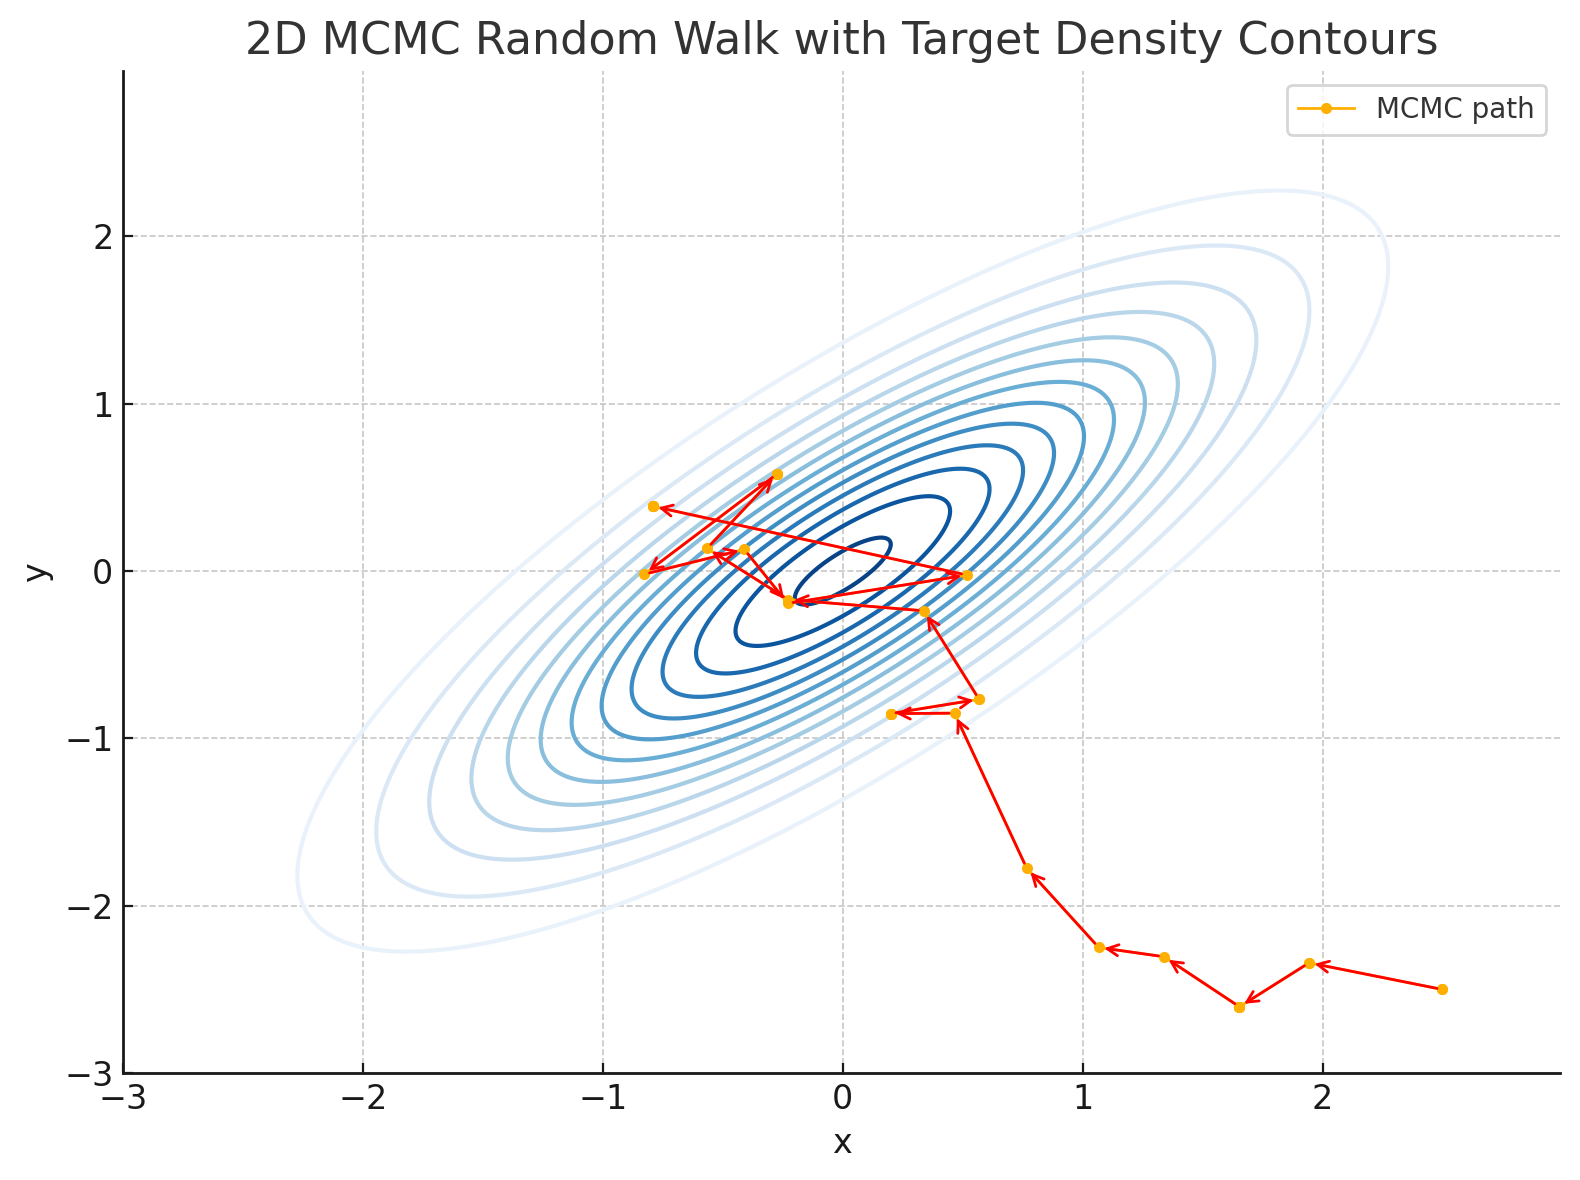

In [4]:
!pip install blackjax

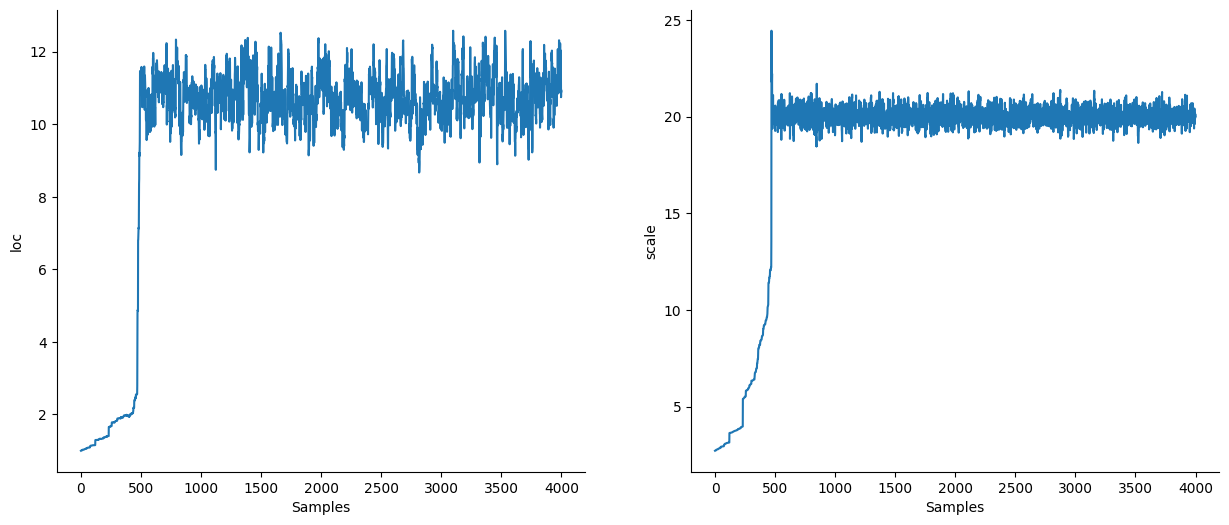

In [9]:
# warm up
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as rdm
import jax.scipy.stats as stats

import blackjax


seed = 10
rng_key = rdm.PRNGKey(seed)

# true values that generate our observations
rng_key, o_key = rdm.split(rng_key)
loc, scale = 10, 20
observed = loc + scale * rdm.normal(o_key, shape=(1_000,))


# set up our density function
def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return jnp.sum(logpdf)


def logdensity(x):
  return logdensity_fn(**x)


# kernel params
inv_mass_matrix = jnp.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

# set up our kernel
hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)
nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

# sample from posterior
rng_key, sample_key = rdm.split(rng_key)

initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = nuts.init(initial_position)
hmc_kernel = jax.jit(hmc.step)
nuts_kernel = jax.jit(nuts.step)


def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

states = inference_loop(sample_key, nuts_kernel, initial_state, 4_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

# visualize results
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(mcmc_samples["loc"])
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(mcmc_samples["scale"])
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale");

## Bayesian Logistic Regression, revisited

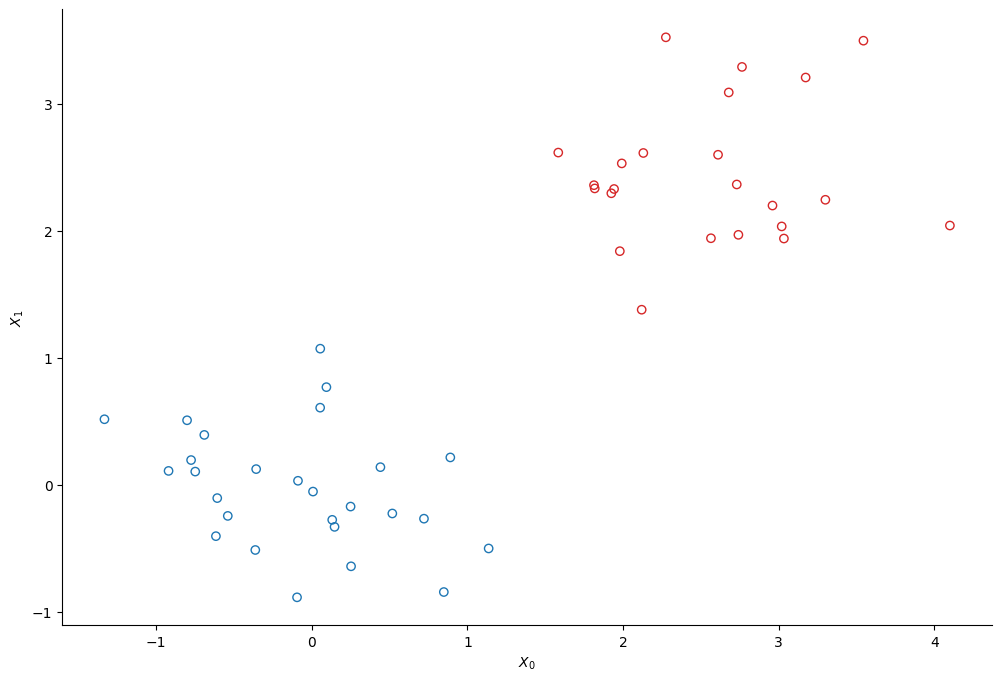

In [3]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import blackjax

from sklearn.datasets import make_biclusters


plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (12, 8)

seed = 0
rng_key = jax.random.key(seed)

# generate data
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

# visualize data/labels
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$");

In [ ]:
# set up likelihoods

Phi = jnp.c_[jnp.ones(num_points)[:, None], X]
N, M = Phi.shape


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))


def logdensity_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    prior_term = alpha * w @ w / 2

    return -prior_term + log_likelihood_term.sum()


# sample initial weights, w
rng_key, init_key = jax.random.split(rng_key)

w0 = jax.random.multivariate_normal(init_key, 0.1 + jnp.zeros(M), jnp.eye(M))
rmh = blackjax.rmh(logdensity_fn, blackjax.mcmc.random_walk.normal(jnp.ones(M) * 0.05))
initial_state = rmh.init(w0)

# set up inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# perform inference and sample
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, rmh.step, initial_state, 5_000)

In [ ]:
burnin = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()